In [1]:
#!/usr/bin/env python
# coding: utf-8


import os
import torch, pyro, numpy as np
torch.set_default_tensor_type(torch.cuda.FloatTensor)

import swyft
import click
from swyft.networks.normalization import OnlineNormalizationLayer


from torch import tensor
import torch.nn as nn
import torchvision.transforms.functional as TF

DEVICE = 'cuda'

from utils import *
from network import UNET, CustomHead

import sys
sys.path.append('/home/eliasd/lensing/elias_utils')
from plotting import *

imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower')




m = 1
nsub = 3
nsim = 10000

lr = 1e-3
factor = 1e-1
patience = 5
max_epochs = 30

In [2]:
SYSTEM_NAME = "ngc4414"
RUN = f'_M_m{m}_nsub{nsub}_nsim{nsim}'
assert os.path.exists(f'/nfs/scratch/eliasd/store{RUN}.sync')
SIM_PATH = f'/nfs/scratch/eliasd/store{RUN}.zarr' 
print('run', RUN)

run _M_m1_nsub3_nsim10000


In [3]:
# Set utilities
store = swyft.DirectoryStore(path=SIM_PATH)
print(f'Store has {len(store)} simulations')

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
CONFIG = get_config(SYSTEM_NAME, str(nsub), str(m))
torch.set_default_tensor_type(torch.FloatTensor)

Loading existing store.
Store has 10042 simulations


In [4]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
ppd = CONFIG.ppd()['model_trace'].nodes
torch.set_default_tensor_type(torch.FloatTensor)

In [5]:
prior, uv = get_prior(CONFIG)

In [6]:
# Set up posterior
idx = 0
img_0 = store[idx][0]['image']
L1, L2 = torch.tensor(img_0.shape)
assert L1 == L2
L = L1.item()
print(f'L = {L}')

torch.set_default_tensor_type(torch.FloatTensor)
dataset = swyft.Dataset(nsim, prior, store)#, simhook = noise)
marginals = [i for i in range(L**2)]
post = swyft.Posteriors(dataset)

L = 40


In [7]:
# def coord_uv(coords_u, lows, highs):
    
#     lows = np.full(u.shape, np.tile(lows, 3))
#     highs = np.full(u.shape, np.tile(highs, 3))    

#     v = lambda u: (highs - lows) * u + lows
#     coords_v = v(coords_u)
#     return coords_v

# def coord_to_map(XY_u):
    
#     lows = [-2.5, -2.5, 10]
#     highs = [2.5, 2.5, 12]
#     lows_m, highs_m = lows[2], highs[2]
    
#     print(XY_u.shape)

#     XY = tensor(coord_uv(XY_u.numpy(), lows, highs))
    

#     n_batch =  XY.shape[0]
#     n_coords = XY.shape[1]*2/3
#     n_m = 4
    
#     assert n_coords.is_integer()
    
#     x_sub_u, y_sub_u, log10_m_sub_u = XY_u.view(-1,3).T.to(DEVICE)
#     x_sub, y_sub, log10_m_sub = XY.view(-1,3).T.to(DEVICE)    


#     binary_map = torch.zeros((n_batch, n_m, L, L), device = DEVICE)


#     x_i = torch.floor((x_sub_u*L).flatten()).type(torch.long) 
#     y_i = torch.floor((y_sub_u*L).flatten()).type(torch.long) 
#     m_i = torch.floor( (log10_m_sub - lows_m) / (highs_m - lows_m) * n_m ).type(torch.long)
    

#     if n_coords != 0:
#         i   = torch.floor(torch.arange(0, n_batch, 1/n_coords*2).to(DEVICE)).type(torch.long)
#         xx = tuple(torch.stack((i, m_i, y_i, x_i)))
#         binary_map[xx] = 1

#     return binary_map


# # u = dataset[1][1].unsqueeze(0)
# u = torch.stack((dataset[0][1], dataset[1][1]))

# img = coord_to_map(u)

# print(img.shape)


# plt_imshow(img.view(-1, 40, 40), 2)

In [8]:
count = 0
for _ in range(1000000):
    if np.random.uniform() > 0.9:
#         print('ues')
        count += 1
print(count)

100285


In [9]:
a, b = 1, 1
if not (a == 0 or b == 0):
    print(a, b)

1 1


In [10]:
class DoubleConv(swyft.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False), # bias = False becaise BatchNorm2d is set
            nn.BatchNorm2d(out_channels), # BatchNorm2d were not known when paper came out
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(swyft.Module):
    def __init__(self, n_features, marginals):
        super().__init__(n_features, marginals) 
#         super(UNET, self).__init__()
        
        self.marginals = marginals
        self.n_features = n_features
        
        self.L = 40
        self.n_m = 2
        
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # keep size the same
        
        in_channels  = 1
        out_channels = self.n_m + 1
        features=[64, 128, 256, 512]

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
    def coord_uv(self, coords_u, lows, highs):
                
        n = len(coords_u[0])/3
        assert n.is_integer()
        n = int(n)

        lows = np.full(coords_u.shape, np.tile(lows, n))
        highs = np.full(coords_u.shape, np.tile(highs, n))   
                

        v = lambda u: (highs - lows) * u + lows
        coords_v = v(coords_u)
        return coords_v

    def coord_to_map(self, XY_u):

        
        n_batch =  XY_u.shape[0]
        n_coords = XY_u.shape[1]*2/3
        
        binary_map = torch.zeros((n_batch, self.n_m + 1, self.L, self.L), device = DEVICE)
        
        if not (n_batch == 0 or n_coords == 0):
            

            assert n_coords.is_integer()
            
            lows = [-2.5, -2.5, 10]
            highs = [2.5, 2.5, 12]
            lows_m, highs_m = lows[2], highs[2]


            XY = tensor(self.coord_uv(XY_u.numpy(), lows, highs))
            
            x_sub_u, y_sub_u, log10_m_sub_u = XY_u.view(-1,3).T.to(DEVICE)
            x_sub, y_sub, log10_m_sub = XY.view(-1,3).T.to(DEVICE)    


            x_i = torch.floor((x_sub_u*self.L).flatten()).type(torch.long) 
            y_i = torch.floor((y_sub_u*self.L).flatten()).type(torch.long) 
            m_i = torch.floor( (log10_m_sub - lows_m) / (highs_m - lows_m) * self.n_m ).type(torch.long) + 1


            i   = torch.floor(torch.arange(0, n_batch, 1/n_coords*2).to(DEVICE)).type(torch.long)
            xx = tuple(torch.stack((i, m_i, y_i, x_i)))
            binary_map[xx] = 1

            xx = tuple(torch.stack((i, torch.zeros_like(m_i), y_i, x_i)))
            binary_map[xx] = 1

        return binary_map
        

    def forward(self, sims, target):
                
        sims = sims.view(-1, self.L, self.L)
        z = self.coord_to_map(target)
    
        ############# UNet Start ###
        x = sims
        n_batch = len(x)
        x = x.unsqueeze(1)
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reverse list

        # the upsampling
        for idx in range(0, len(self.ups), 2): # step of 2 because we want up - double column - up - double column
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2] # //2 because we want still steps of one

            # if statement because we can put in shapes that are not divisble by two around 19:00 of video
            if x.shape != skip_connection.shape: 
                x = TF.resize(x, size=skip_connection.shape[2:]) # hopefully does not impact accuracy too much

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        x = self.final_conv(x)
        ############# UNet End ###
        
        z[:,0] = 1 - z[:,0]
        x = x * z        

#         if np.random.uniform() > 0.995:
#             plots = torch.cat((x_new[0], z[0]))
#             plt_imshow(plots, cbar = True, titles = ['x0', 'x1', 'x2', 'z0', 'z1', 'z2'])
        
        x = x.view(-1, self.n_features * (self.n_m + 1))
        return x

class CustomHead(swyft.Module):

    def __init__(self, obs_shapes) -> None:
        super().__init__(obs_shapes=obs_shapes)
        self.n_features = torch.prod(tensor(obs_shapes['image']))
        self.onl_norm = OnlineNormalizationLayer(torch.Size([self.n_features]))

    def forward(self, obs) -> torch.Tensor:
        x = obs["image"]
        n_batch = len(x)
        x = x.view(n_batch, self.n_features)
#         x = self.onl_norm(x)    
        return x

In [4]:
# Train

save_name, save_path = get_name(RUN, lr, factor, patience)
print(f'Training {save_name}!')

# torch.set_default_tensor_type(torch.FloatTensor)
# post = swyft.Posteriors(dataset)
# post.add(marginals, device = DEVICE, head = CustomHead, tail = UNET)
# post.train(marginals, max_epochs = max_epochs,
#            optimizer_args = dict(lr=lr),
#            scheduler_args = dict(factor = factor, patience = patience)
#           )

# post.save(save_path)
# print('Done!')

post = swyft.Posteriors.load(save_path).to(DEVICE)

Training UNet_M_m1_nsub3_nsim10000_lr-3.0_fac-1.0_pat5.pt!


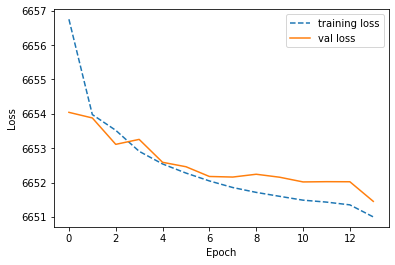

In [5]:
def get_losses(post):
        
    keys = list(post._ratios.keys())
    assert len(keys) == 1
    losses = post._ratios[keys[0]]._train_diagnostics
    assert len(losses) == 1
    tl = losses[0]['train_loss']
    vl = losses[0]['valid_loss']
    epochs = np.arange(len(tl))
    return epochs, tl, vl

def plot_losses(post, title = ''):
    fig, ax = plt.subplots(1, 1)
    
    epochs, tl, vl = get_losses(post)
        
    ax.plot(epochs, tl, '--', label = f'training loss')
    ax.plot(epochs, vl, '-', label = f'val loss')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    plt.legend()
    plt.show()
    
plot_losses(post)

In [6]:
n_m = 2
L = 40

grid = torch.linspace(0,(L-1)/L,L)
x, y = torch.meshgrid(grid, grid, indexing = 'xy')
ms = [torch.full((L*L,), m_i) for m_i in np.linspace(0, 1, 2*n_m+1)[1::2]]

coords = [tensor(()).view(1, -1)]
for m in ms:
    coords.append(
        torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1).reshape(1, -1)
    )

uuu = UNET(1, 1)
plots = [uuu.coord_to_map(coord.to(DEVICE)).cpu().squeeze() for coord in coords]


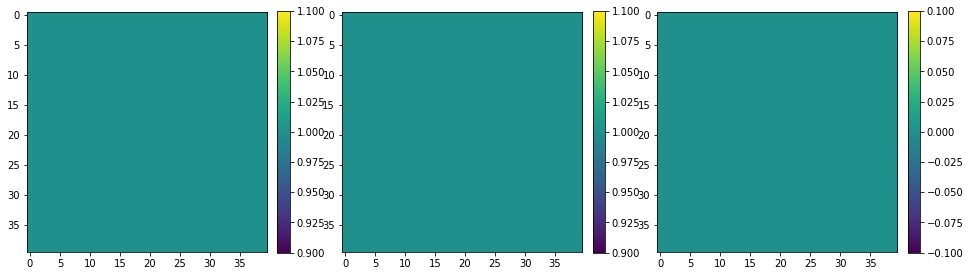

In [7]:
uuu = UNET(1, 1)
L = 40
grid = torch.linspace(0,(L-1)/L,L)
x, y = torch.meshgrid(grid, grid, indexing = 'xy')
m = torch.full((L*L,), 0.25)
xy_full = torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1).flatten()
xy_empty = tensor(())


uuu = UNET(1, 1)
plots = [uuu.coord_to_map(xy.view(1, -1).to(DEVICE)).cpu().squeeze() for xy in [xy_full]]

plt_imshow(plots[0], cbar = True)

In [8]:
def ratio(w):
    r = np.zeros((L**2))
    for i, (key, value) in enumerate(w.items()):
        r[i] = value
    return r.T.reshape(L, L)

def get_ratio(post, obs0, coords):
    samples = post.sample_elias(N = 1, obs0 = (obs0), n_batch = 1, v = coords.view(1, -1))
    v = samples['v']
    w = samples['weights']
    return ratio(w)

In [9]:
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

i = np.random.randint(0, len(store))
obs0 = dataset[i][0]
v0 = dataset[i][2]
u0 = dataset[i][1]

# obs0['image'] = torch.tensor(obs0['image']).unsqueeze(0)
obs0['image'] = obs0['image'].unsqueeze(0)

NameError: name 'dataset' is not defined

In [59]:
re = list(post._ratios.values())[0]
head = re.head.eval()
tail = re.tail.eval()


f = head(obs0).to(DEVICE, dtype = torch.float)

ratios = np.zeros((n_m + 1, L, L))

for i, coord in enumerate(coords):

    params = coord.to(DEVICE, dtype = torch.float)
    logratio = tail(f, params)
    ratio = np.exp(logratio.numpy()).reshape(n_m + 1, L, L)
    
    ratios[i] = ratio[i]


In [60]:
target = uuu.coord_to_map(u0.unsqueeze(0)).squeeze().numpy()

In [63]:
plots = np.concatenate((target, ratios))

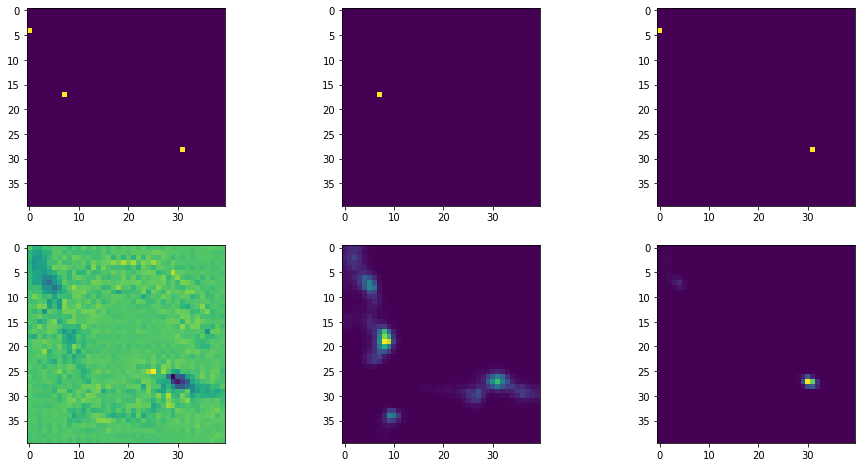

In [64]:
plt_imshow(plots, 2)